# Imports

In [61]:
# General libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn model selection and metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Scikit-learn transformers and preprocessors & Feature Selection
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import make_pipeline

# Scikit-learn regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import pandas as pd 
import numpy as np 
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML

# External regressor
import xgboost as xgb

# Miscellaneous settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [62]:
houses = pd.read_csv('https://raw.githubusercontent.com/MerleSt/HousingPricePrediction/main/Data/housing_prices.csv')

In [63]:
houses.drop(columns=['Id'], inplace=True)

In [64]:
houses['MSSubClass'] = houses['MSSubClass'].astype('object')

# Split Data

In [65]:
X = houses.copy()
X.drop(columns='SalePrice', inplace=True)
y = np.log(houses['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Missing Values

In [66]:
# # Temporarily set the display options to show all rows
# pd.set_option('display.max_rows', None)

# # Display the NaN counts for all columns
# print(X_train.isna().sum())

# # Reset the display options back to default settings
# pd.reset_option('display.max_rows')

In [67]:
# After inspection we find that where there is not fireplace fireplacequ was set to missing instead of 'NA'
X_train.loc[X_train['Fireplaces'] == 0, 'FireplaceQu'] = 'NA'

In [68]:
garage_null_rows = X_train[X_train['GarageCond'].isnull()]

# Display just the garage-related columns for these rows
garage_columns = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
garage_null_rows[garage_columns]

# Let us reset the columns to 'NA'

# List of columns to update
cols_to_update = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Set those columns to 'NA' where GarageArea is 0
X_train.loc[X_train['GarageArea'] == 0, cols_to_update] = 'NA'
X_train.loc[X_train['GarageArea'] == 0, 'GarageYrBlt'] = -9999

In [69]:
pool_null_rows = X_train[X_train['PoolQC'].isnull()]

# Display just the pool-related columns for these rows
pool_columns = ['PoolArea', 'PoolQC']
pool_null_rows[pool_columns]

# Just as I thought, let us replace the missing values with 'NA'
X_train.loc[X_train['PoolArea'] == 0, 'PoolQC'] = 'NA'

In [70]:
# Let us check the Fence
X_train[X_train['Fence'] == 'NA']
X_train['Fence'].fillna('NA', inplace=True)

In [71]:
# MiscFeature
X_train[X_train['MiscFeature'] == 'NA']
X_train['MiscFeature'].fillna('NA', inplace=True)

In [72]:
# Alley
X_train[X_train['Alley'] == 'NA']
X_train['Alley'].fillna('NA', inplace=True)

In [73]:
# Doesnt work for LotFrontage so it will be needed to use SimpleImputer

In [74]:
# Electrical we dont know, so since it is only one observation

In [75]:
# All Basement Columns
no_basement_rows = X_train[X_train['TotalBsmtSF'] == 0]

# Define the list of basement-related columns
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
                'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

# Display the values in the basement-related columns for these rows
no_basement_rows[bsmt_columns]

# List of columns to update based on your provided list
bsmt_columns_to_update = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

X_train.loc[X_train['TotalBsmtSF'] == 0, bsmt_columns_to_update] = 'NA'

## Independent Vriable Normalize

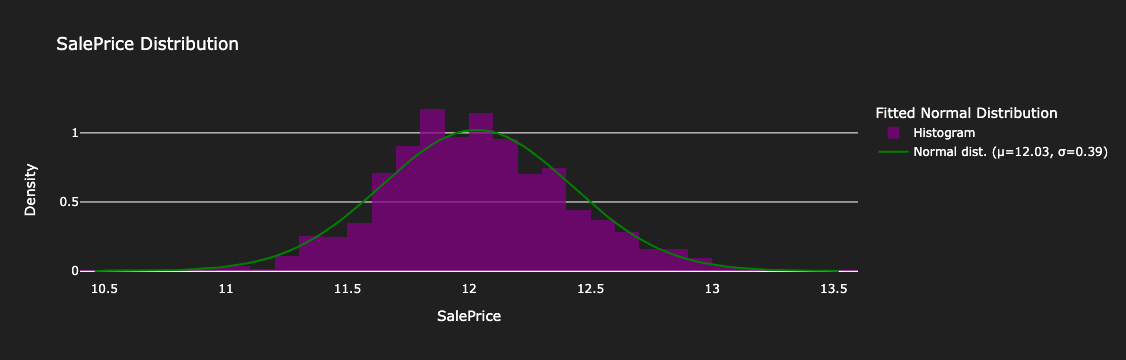

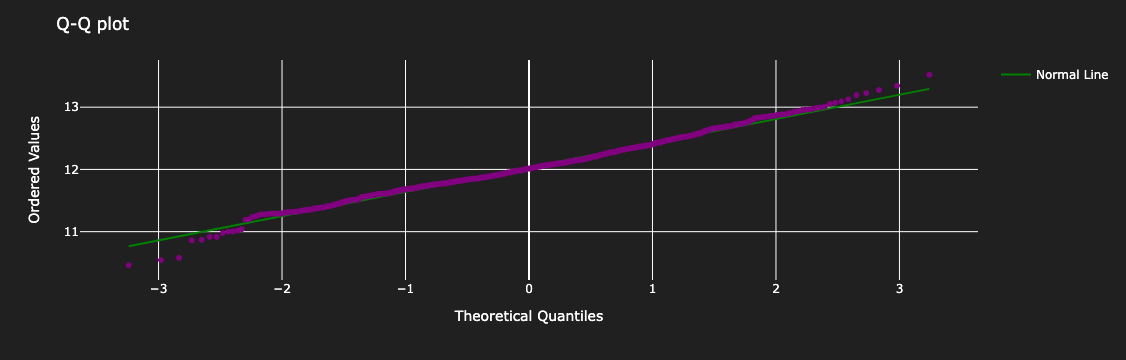

In [76]:
import scipy.stats as stats

# Fit a normal distribution to the SalePrice data
mu, sigma = stats.norm.fit(y_train)

# Create a histogram of the SalePrice column
hist_data = go.Histogram(x=y_train, nbinsx=50, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='purple'))

# Calculate the normal distribution based on the fitted parameters
x_norm = np.linspace(y_train.min(), y_train.max(), 100)
y_norm = stats.norm.pdf(x_norm, mu, sigma)

# Create the normal distribution overlay
norm_data = go.Scatter(x=x_norm, y=y_norm, mode="lines", name=f"Normal dist. (μ={mu:.2f}, σ={sigma:.2f})", line=dict(color="green"))

# Combine the histogram and the overlay
fig = go.Figure(data=[hist_data, norm_data])

# Set the layout for the plot
fig.update_layout(
    title="SalePrice Distribution",
    xaxis_title="SalePrice",
    yaxis_title="Density",
    legend_title_text="Fitted Normal Distribution",
    plot_bgcolor='rgba(32, 32, 32, 1)',
    paper_bgcolor='rgba(32, 32, 32, 1)',
    font=dict(color='white')
)

# Create a Q-Q plot
qq_data = stats.probplot(y_train, dist="norm")
qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["purple"])
qq_fig.update_layout(
    title="Q-Q plot",
    plot_bgcolor='rgba(32, 32, 32, 1)',
    paper_bgcolor='rgba(32, 32, 32, 1)',
    font=dict(color='white')
)

# Calculate the line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
line_x = np.array(qq_data[0][0])
line_y = intercept + slope * line_x

# Add the line of best fit to the Q-Q plot
line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="green"))

# Update the Q-Q plot with the normal line
qq_fig.add_trace(line_data)

# Show the plots
fig.show()
qq_fig.show()

Use Log Transformation later on since the Data are skewed.

# Preprocess Data

 Let us remember the LotFrontage is the only one with missing values.

In [77]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

### Select From Model

In [78]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean')
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
)

In [79]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_features),
    ('cat_pipe', cat_pipeline, cat_features)
], remainder='passthrough')

In [80]:
from sklearn.preprocessing import FunctionTransformer

# feature engineering functions 
def custom_features(df):
    df_out = df.copy()
    df_out['PropertyAge'] = df_out['YrSold'] - df_out['YearBuilt']
    df_out['TotalSF'] = df_out['TotalBsmtSF'] + df_out['1stFlrSF'] + df_out['2ndFlrSF']
    df_out['TotalBath'] = df_out['FullBath'] + 0.5 * df_out['HalfBath'] + df_out['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df_out['HasRemodeled'] = (df_out['YearRemodAdd'] != df_out['YearBuilt']).astype(object)
    df_out['Has2ndFloor'] = (df_out['2ndFlrSF'] > 0).astype(object)
    df_out['HasGarage'] = (df_out['GarageArea'] > 0).astype(object)
    df_out['YrSold_cat'] = df_out['YrSold'].astype(object)
    df_out['MoSold_cat'] = df_out['MoSold'].astype(object)
    df_out['YearBuilt_cat'] = df_out['YearBuilt'].astype(object)
    df_out['MSSubClass_cat'] = df_out['MSSubClass'].astype(object)
    
    return df_out

feature_engineering_transformer = FunctionTransformer(custom_features)

In [81]:
pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), SelectFromModel(RandomForestRegressor(random_state=42)), RandomForestRegressor(random_state=42))

In [82]:
pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), RandomForestRegressor(random_state=42))

In [83]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x2b21fef20>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir', ...])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [84]:
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,0.1,0.148167,0.008301,0.882359


## XGB

In [98]:
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
model_GBR =  HistGradientBoostingRegressor(loss='squared_error', learning_rate = 0.05,random_state=1)
pipeline = make_pipeline(feature_engineering_transformer, preprocessor, StandardScaler(), model_GBR)

In [107]:
param_grid = {
    'histgradientboostingregressor__learning_rate': [0.01, 0.1, 0.3],
    'histgradientboostingregressor__max_depth': [3, 6, 10]
}

In [108]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [109]:
search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-2,
    verbose=2)

In [110]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/merlesteffen/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was rename

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function custom_features at 0x2b21fef20>)),
                                       ('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['LotFrontage',
                                                                          'LotArea',
                                                                          'Overa...
                                                                          'HeatingQC',
                                                                          'CentralAir', ...])])),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(learning_rate=0.05,
                                                                      random_state=1))]),
             n_jobs=-2,
             param_grid={'histgradientboostingregressor__learning_rate': [0.01,
                                                                          0.1,
                                                                          0.3],
                         'histgradientboostingregressor__max_depth': [3, 6,
                                                                      10]},
             scoring='neg_mean_squared_error', verbose=2)

In [111]:
predictions = search.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions)
r2 = r2_score(y_true=y_test, y_pred=predictions)

model_df = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "MAPE": [mape],
    "R2": [r2]},
)
model_df

,MAE,RMSE,MAPE,R2
0,0.09,0.13776,0.007754,0.898304


# Submission

In [112]:
new_data = pd.read_csv('/Users/merlesteffen/Downloads/test (1).csv')
id_col = new_data.pop('Id')

In [113]:
new_data['MSSubClass'] = new_data['MSSubClass'].astype('object')

In [114]:
search.best_estimator_.fit(X,y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function custom_features at 0x2b21fef20>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1...
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir', ...])])),
                ('standardscaler', StandardScaler()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(max_depth=3, random_state=1))])

In [115]:
prices_log = search.best_estimator_.predict(new_data)
prices = np.exp(prices_log)
prices

array([118383.66103382, 157100.90835714, 180690.36875956, ...,
       160029.36547227, 121078.94576415, 225487.66790147])

In [116]:
submission_file = pd.DataFrame({
    'Id':id_col,
    'SalePrice':prices
})
submission_file

,Id,SalePrice
0,1461,118383.661034
1,1462,157100.908357
2,1463,180690.368760
3,1464,187891.346949
4,1465,180926.596046
...,...,...
1454,2915,81137.939328
1455,2916,85540.211198
1456,2917,160029.365472
1457,2918,121078.945764


In [117]:
submission_file.to_csv('submission2.csv',index=False)